# **Assignment 4 - Deep Learning**

**Deep Learning**


This assignment covers image classification with deep learning. You will train and evaluate three different categories of networks on the Imagenette dataset. For each model, it is recommended that you implement them using PyTorch Lightning. Feel free to adapt the code from the demos we did in class. A getting started codebase has been provided in this repository.

For all tasks, free CPU compute time and possible GPU time is available through Google Colab.

In [1]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**A Basic CNN**


The first network will be a basic CNN. This network should include some number of convolutional layers followed by fully connected layers. There is no size requirement for this network nor is there a performance requirement. Train the model until convergence. Implement some form of early stopping in case the model begins to overfit.

In your report, describe the chosen architecture and include the training loss, validation loss, and final test accuracy of the model.

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics
from torchvision import transforms
from torchvision.datasets import Imagenette
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

# --- CNN Model Definition ---
class BasicCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        # Define convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: Grayscale (1 channel)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Define fully connected layers for classification
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Input size after pooling: 128 channels * 8x8 spatial dimensions
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Output: Number of classes

        # Metrics for training, validation, and testing accuracy
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        # Flatten the feature map and pass through fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Output logits for classification

    def training_step(self, batch, batch_idx):
        # Unpack batch data (input images and labels)
        x, y = batch
        y_hat = self(x)  # Forward pass
        loss = F.cross_entropy(y_hat, y)  # Compute cross-entropy loss
        acc = self.train_accuracy(y_hat.softmax(dim=-1), y)  # Compute accuracy

        # Log training metrics (loss and accuracy) with epoch-level aggregation
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # Validation step to compute loss and accuracy on validation data
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_accuracy(y_hat.softmax(dim=-1), y)

        # Log validation metrics (loss and accuracy) with epoch-level aggregation
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # Test step to compute loss and accuracy on test data
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.test_accuracy(y_hat.softmax(dim=-1), y)

        # Log test metrics (loss and accuracy)
        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        # Use Adam optimizer for training the model with a learning rate of 1e-3
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# --- Data Preparation ---
# Define transformations for training data (cropping, resizing, normalization)
train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.Grayscale(),  # Convert images to grayscale (single channel)
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2470,))
])

# Define transformations for test/validation data (similar to training but without augmentation)
test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2470,))
])

# Load Imagenette dataset for training and testing; download if not already available
train_dataset = Imagenette("data/imagenette", split="train", size="160px", download=True, transform=train_transforms)
test_dataset = Imagenette("data/imagenette", split="val", size="160px", download=True, transform=test_transforms)

# Split training dataset into train/validation sets (90% train / 10% validation split)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                           [train_size, val_size],
                                                           generator=torch.Generator().manual_seed(42))
val_dataset.dataset.transform = test_transforms  # Apply test transformations to validation set

# Create DataLoaders for training/validation/test datasets with appropriate batch sizes and workers
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=8)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=128,
                                         num_workers=8)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=256,
                                          num_workers=8)

# --- Training Setup ---
model = BasicCNN()  # Instantiate the CNN model

# Define callbacks: Early stopping to prevent overfitting and checkpointing to save the best model
callbacks = [
    EarlyStopping(monitor="val_loss", mode="min", patience=5),
    ModelCheckpoint(monitor="val_loss", mode="min")
]

# Initialize PyTorch Lightning trainer with callbacks and maximum epochs set to 20
trainer = L.Trainer(
    max_epochs=20,
    callbacks=callbacks,
    accelerator="auto"
)

# --- Training ---
trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

# --- Final Metrics ---
# Retrieve final metrics from the trainer after training is complete; fallback to NaN if not available
metrics = {
    "train_loss": trainer.callback_metrics.get("train_loss_epoch", torch.tensor(float('nan'))).item(),
    "train_acc": trainer.callback_metrics.get("train_acc_epoch", torch.tensor(float('nan'))).item(),
    "val_loss": trainer.callback_metrics.get("val_loss", torch.tensor(float('nan'))).item(),
    "val_acc": trainer.callback_metrics.get("val_acc", torch.tensor(float('nan'))).item()
}

print("\nFinal Metrics:")
print(f"Train Loss: {metrics['train_loss']:.4f}")
print(f"Train Accuracy: {metrics['train_acc']:.4f}")
print(f"Validation Loss: {metrics['val_loss']:.4f}")
print(f"Validation Accuracy: {metrics['val_acc']:.4f}")

# --- Testing ---
trainer.test(model=model,
             dataloaders=test_loader)  # Evaluate the model on the test dataset; logs test metrics automatically.


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | conv3          | Conv2d             | 73.9 K | train
3 | fc1            | Linear             | 4.2 M  | train
4 | fc2            | Linear             | 65.7 K | train
5 | fc3            | Linear             | 1.3 K  | train
6 | train_accuracy | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Final Metrics:
Train Loss: 0.1295
Train Accuracy: 0.9628
Validation Loss: 1.9147
Validation Accuracy: 0.5977


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6017834544181824     │
│         test_loss         │    1.9490283727645874     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.9490283727645874, 'test_acc': 0.6017834544181824}]

**ResNet 18**


The second network will be a ResNet 18. This network is a popular choice for image classification tasks. Train the model until convergence. Implement some form of early stopping in case the model begins to overfit.

In your report, describe the chosen architecture and include the training loss, validation loss, and final test accuracy of the model.

In [16]:
# --- Core Imports ---
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L  # PyTorch Lightning framework
import torchmetrics  # For standardized metric calculation
from torchvision import models, transforms  # Pretrained models and image transforms
from torchvision.datasets import Imagenette  # Lightweight image dataset
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader

# --- ResNet18 Model Definition ---
class ResNet18Model(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        # Load pretrained ResNet18 (trained on ImageNet)
        self.resnet18 = models.resnet18(pretrained=True)

        # Replace final fully connected layer for our specific task
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

        # Initialize accuracy trackers for all phases
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        # Forward pass through ResNet18
        return self.resnet18(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # Model predictions
        loss = F.cross_entropy(y_hat, y)  # Compute loss

        # Track accuracy and log metrics (epoch-level aggregation)
        self.train_accuracy(y_hat.softmax(dim=-1), y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_accuracy, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Track validation metrics
        self.val_accuracy(y_hat.softmax(dim=-1), y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_accuracy, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Track test metrics
        self.test_accuracy(y_hat.softmax(dim=-1), y)
        self.log("test_loss", loss)
        self.log("test_acc", self.test_accuracy)

    def configure_optimizers(self):
        # Adam optimizer with default learning rate
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# --- Data Preparation ---
# Training data transformations (with 3-channel normalization for ResNet)
train_transforms = transforms.Compose([
    transforms.CenterCrop(160),  # Center crop to 160x160
    transforms.Resize(64),       # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Imagenette stats
])

# Test/validation transformations (no augmentation)
test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load Imagenette dataset
train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px",
                          download=True, transform=train_transforms)
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px",
                         download=True, transform=test_transforms)

# Split training data into train/validation sets (90/10 split)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)
val_dataset.dataset.transform = test_transforms  # Apply test transforms to validation

# Create data loaders with optimal settings
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8)

# --- Training Setup ---
model = ResNet18Model()

# Callbacks for training optimization
callbacks = [
    EarlyStopping(monitor="val_loss", mode="min", patience=5),  # Stop if no improvement
    ModelCheckpoint(monitor="val_loss", mode="min")  # Save best model
]

# Configure trainer with automatic accelerator selection
trainer = L.Trainer(
    max_epochs=20,
    callbacks=callbacks,
    accelerator="auto"  # Automatically uses GPU if available
)

# --- Model Training ---
trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

# --- Final Metrics ---
# Safely retrieve metrics with NaN fallback values
metrics = {
    "train_loss": trainer.callback_metrics.get("train_loss_epoch", torch.tensor(float('nan'))).item(),
    "train_acc": trainer.callback_metrics.get("train_acc_epoch", torch.tensor(float('nan'))).item(),
    "val_loss": trainer.callback_metrics.get("val_loss", torch.tensor(float('nan'))).item(),
    "val_acc": trainer.callback_metrics.get("val_acc", torch.tensor(float('nan'))).item()
}

# Print formatted metrics
print("\n=== Final Metrics ===")
print(f"Train Loss: {metrics['train_loss']:.4f}")
print(f"Train Accuracy: {metrics['train_acc']:.4f}")
print(f"Validation Loss: {metrics['val_loss']:.4f}")
print(f"Validation Accuracy: {metrics['val_acc']:.4f}")

# --- Model Testing ---
trainer.test(model=model, dataloaders=test_loader)  # Automatically logs test metrics


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | resnet18       | ResNet             | 11.2 M | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



=== Final Metrics ===
Train Loss: 0.0794
Train Accuracy: 0.9729
Validation Loss: 1.0493
Validation Accuracy: 0.7730


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7750318646430969     │
│         test_loss         │    0.9974966645240784     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9974966645240784, 'test_acc': 0.7750318646430969}]

**Regularization**


Pick one of the models used in the previous two sections and add regularization in the form of data augmentation or dropout. Train the model until convergence.

In your report, describe your choice of data augmentation and provide a clear comparison of the model with and without regularization.

In [19]:
# --- Core Imports ---
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L  # PyTorch Lightning framework
import torchmetrics  # For standardized metric calculation
from torchvision import models, transforms  # Pretrained models and image transforms
from torchvision.datasets import Imagenette  # Lightweight image dataset
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader

# --- Model Definition ---
class ResNet18ModelWithRegularization(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        # Load pretrained ResNet18 (ImageNet weights)
        self.resnet18 = models.resnet18(pretrained=True)

        # Replace final fully connected layer for transfer learning
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

        # Separate accuracy trackers for each phase
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        # Forward pass through ResNet18
        return self.resnet18(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # Model predictions
        loss = F.cross_entropy(y_hat, y)  # Compute loss

        # Track accuracy and log metrics (epoch-level aggregation)
        self.train_accuracy(y_hat.softmax(dim=-1), y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_accuracy, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Track validation metrics
        self.val_accuracy(y_hat.softmax(dim=-1), y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_accuracy, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Track test metrics
        self.test_accuracy(y_hat.softmax(dim=-1), y)
        self.log("test_loss", loss)
        self.log("test_acc", self.test_accuracy)

    def configure_optimizers(self):
        # Adam optimizer with default learning rate
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# --- Data Augmentation Pipeline ---
train_transforms = transforms.Compose([
    transforms.CenterCrop(160),  # Center crop to 160x160
    transforms.Resize(64),       # Resize to 64x64
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),      # ±30 degree rotation
    transforms.ColorJitter(              # Random color adjustments
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.2
    ),
    transforms.ToTensor(),
    # Normalize with Imagenette-specific statistics
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Test/validation transformations (no augmentation)
test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# --- Dataset Preparation ---
train_dataset = Imagenette(
    "data/imagenette/train/",
    split="train",
    size="160px",
    download=True,
    transform=train_transforms
)
test_dataset = Imagenette(
    "data/imagenette/test/",
    split="val",
    size="160px",
    download=True,
    transform=test_transforms
)

# Split training data into 90% train / 10% validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Reproducible split
)
val_dataset.dataset.transform = test_transforms  # Apply test transforms to validation

# --- DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8  # Parallel data loading
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8
)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8
)

# --- Training Configuration ---
model = ResNet18ModelWithRegularization()

# Model checkpointing (saves best weights only)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",        # Track validation loss
    mode="min",               # Minimize the monitored metric
    filename="best_model_weights_reg",  # Custom filename
    save_top_k=1,             # Save only the best model
    dirpath="checkpoints/",   # Save directory
    save_weights_only=True    # Save only model weights (smaller files)
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5  # Stop after 5 epochs without improvement
)

# Initialize trainer with configurations
trainer = L.Trainer(
    callbacks=[early_stop, checkpoint_callback],
    max_epochs=20,
    accelerator="auto"  # Automatically uses GPU if available
)

# --- Model Training ---
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# --- Final Metrics ---
# Safely retrieve metrics with NaN fallback values
metrics = {
    "train_loss": trainer.callback_metrics.get("train_loss_epoch", torch.tensor(float('nan'))).item(),
    "train_acc": trainer.callback_metrics.get("train_acc_epoch", torch.tensor(float('nan'))).item(),
    "val_loss": trainer.callback_metrics.get("val_loss", torch.tensor(float('nan'))).item(),
    "val_acc": trainer.callback_metrics.get("val_acc", torch.tensor(float('nan'))).item()
}

# Print formatted metrics
print("\n=== Final Metrics ===")
print(f"Train Loss: {metrics['train_loss']:.4f}")
print(f"Train Accuracy: {metrics['train_acc']:.4f}")
print(f"Validation Loss: {metrics['val_loss']:.4f}")
print(f"Validation Accuracy: {metrics['val_acc']:.4f}")

# --- Model Testing ---
trainer.test(model=model, dataloaders=test_loader)  # Automatically logs test metrics


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | resnet18       | ResNet             | 11.2 M | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



=== Final Metrics ===
Train Loss: 0.0888
Train Accuracy: 0.9705
Validation Loss: 0.8388
Validation Accuracy: 0.8110


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8107006549835205     │
│         test_loss         │    0.8236585855484009     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8236585855484009, 'test_acc': 0.8107006549835205}]

**Transfer Learning**


Transfer learning is an effective way to leverage features learned from another task into a new task. For this part, use a model that was trained on the Imagenette dataset and fine-tune it using the CIFAR10 dataset. You can refer to the class demonstration of transfer learning to help get started.

Using a model from a previous run, re-train it from scratch on the CIFAR10 dataset. Take the same model and initialize it with pre-trained weights from the Imagenette dataset. With the pre-trained model, fine-tune it on the CIFAR10 dataset.

In your report, describe the pre-trained model you chose to use and include the fine-tuning training plots along with the final model accuracy.

Loaded pretrained weights from checkpoints/best_model_weights_reg.ckpt
Loaded pretrained weights successfully!


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type   | Params | Mode 
--------------------------------------------
0 | resnet18 | ResNet | 11.2 M | train
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type   | Params | Mode 
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.



Final Metrics:
Metric               Loss       Accuracy  
----------------------------------------
Training             0.4906    0.8263
Validation           0.6422    0.7866
Test                 0.6422    0.7860

Metric Debug Info:
Train batches per epoch: 391
Total train losses: 7820
Val batches per epoch: 40
Total val losses: 802


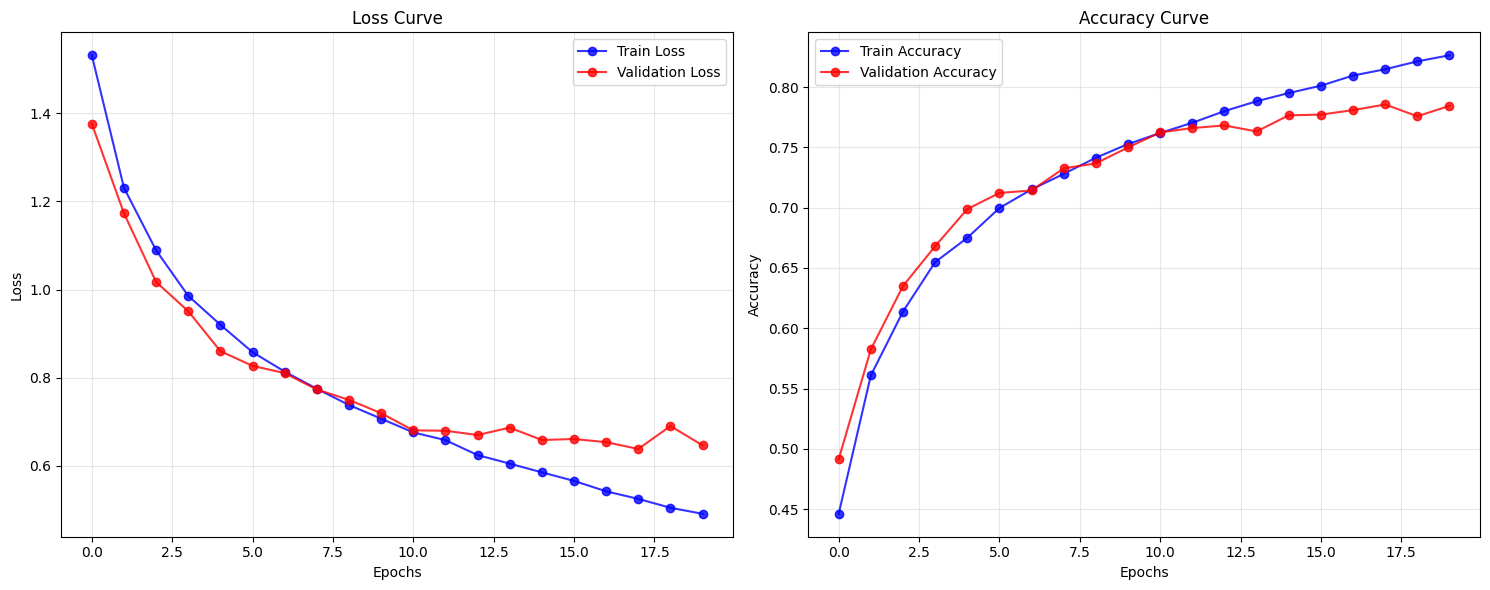

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# --- Model Definition ---
class ResNet18TransferLearning(L.LightningModule):
    def __init__(self, num_classes=10, pretrained_model=None):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

        if pretrained_model is not None:
            self.resnet18.load_state_dict(pretrained_model.state_dict(), strict=False)
            print("Loaded pretrained weights successfully!")

        # Metric trackers
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def forward(self, x):
        return self.resnet18(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()

        # Store metrics
        self.train_losses.append(loss.detach().cpu().item())
        self.train_accuracies.append(acc.detach().cpu().item())

        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()

        # Store metrics
        self.val_losses.append(loss.detach().cpu().item())
        self.val_accuracies.append(acc.detach().cpu().item())

        self.log("val_loss", loss, on_step=True, on_epoch=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# --- Data Preparation ---
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = CIFAR10(root="data/cifar10", train=True, download=True, transform=train_transforms)
test_dataset = CIFAR10(root="data/cifar10", train=False, download=True, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8)

# --- Pretrained Model Loading ---
try:
    pretrained_path = "checkpoints/best_model_weights_reg.ckpt"
    state_dict = torch.load(pretrained_path)["state_dict"]
    state_dict = {k.replace("model.resnet18.", ""): v for k, v in state_dict.items()}

    pretrained_model = models.resnet18(pretrained=False)
    pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 10)
    pretrained_model.load_state_dict(state_dict, strict=False)
    print(f"Loaded pretrained weights from {pretrained_path}")
except FileNotFoundError:
    pretrained_model = None
    print("No pretrained weights found. Training from scratch.")

# --- Training Setup ---
model = ResNet18TransferLearning(num_classes=10, pretrained_model=pretrained_model)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    dirpath="checkpoints/",
    filename="best_model_weights_reg",
    save_weights_only=True
)

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

trainer = L.Trainer(
    callbacks=[early_stop, checkpoint_callback],
    max_epochs=20,
    accelerator="auto"
)

# --- Training ---
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

# --- Final Metrics Report ---
def print_final_metrics(model, test_loader):
    # Test metrics
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for x, y in test_loader:
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            test_loss += loss.item()
            preds = y_hat.argmax(dim=1)
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_total

    # Training metrics (last epoch)
    train_loss = torch.tensor(model.train_losses[-len(train_loader):]).mean().item()
    train_acc = torch.tensor(model.train_accuracies[-len(train_loader):]).mean().item()

    # Validation metrics (last epoch)
    val_loss = torch.tensor(model.val_losses[-len(test_loader):]).mean().item()
    val_acc = torch.tensor(model.val_accuracies[-len(test_loader):]).mean().item()

    print("\nFinal Metrics:")
    print(f"{'Metric':<20} {'Loss':<10} {'Accuracy':<10}")
    print("-" * 40)
    print(f"{'Training':<20} {train_loss:.4f}    {train_acc:.4f}")
    print(f"{'Validation':<20} {val_loss:.4f}    {val_acc:.4f}")
    print(f"{'Test':<20} {test_loss:.4f}    {test_accuracy:.4f}")

# --- Plotting ---
def plot_metrics(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(15, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    if len(train_losses) > 0:
        plt.plot(train_losses, '-o', label='Train Loss', c='blue', alpha=0.8)
    if len(val_losses) > 0:
        plt.plot(val_losses, '-o', label='Validation Loss', c='red', alpha=0.8)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    if len(train_accs) > 0:
        plt.plot(train_accs, '-o', label='Train Accuracy', c='blue', alpha=0.8)
    if len(val_accs) > 0:
        plt.plot(val_accs, '-o', label='Validation Accuracy', c='red', alpha=0.8)
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- Post-Training Processing ---
if len(model.train_losses) > 0 or len(model.val_losses) > 0:
    # Print final metrics
    print_final_metrics(model, test_loader)

    # Training metrics
    train_batches_per_epoch = len(train_loader)
    if len(model.train_losses) > 0:
        epoch_train_losses = torch.tensor(model.train_losses).reshape(-1, train_batches_per_epoch).mean(1).numpy()
        epoch_train_acc = torch.tensor(model.train_accuracies).reshape(-1, train_batches_per_epoch).mean(1).numpy()
    else:
        epoch_train_losses, epoch_train_acc = [], []

    # Validation metrics
    val_batches_per_epoch = len(test_loader)
    total_val_batches = len(model.val_losses)
    if total_val_batches > 0:
        num_val_epochs = total_val_batches // val_batches_per_epoch
        epoch_val_losses = torch.tensor(model.val_losses[:num_val_epochs * val_batches_per_epoch]).reshape(-1, val_batches_per_epoch).mean(1).numpy()
        epoch_val_acc = torch.tensor(model.val_accuracies[:num_val_epochs * val_batches_per_epoch]).reshape(-1, val_batches_per_epoch).mean(1).numpy()
    else:
        epoch_val_losses, epoch_val_acc = [], []

    # Debug prints
    print("\nMetric Debug Info:")
    print(f"Train batches per epoch: {train_batches_per_epoch}")
    print(f"Total train losses: {len(model.train_losses)}")
    print(f"Val batches per epoch: {val_batches_per_epoch}")
    print(f"Total val losses: {total_val_batches}")

    plot_metrics(epoch_train_losses, epoch_train_acc, epoch_val_losses, epoch_val_acc)
else:
    print("No metrics collected - training may not have completed")


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet18 | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


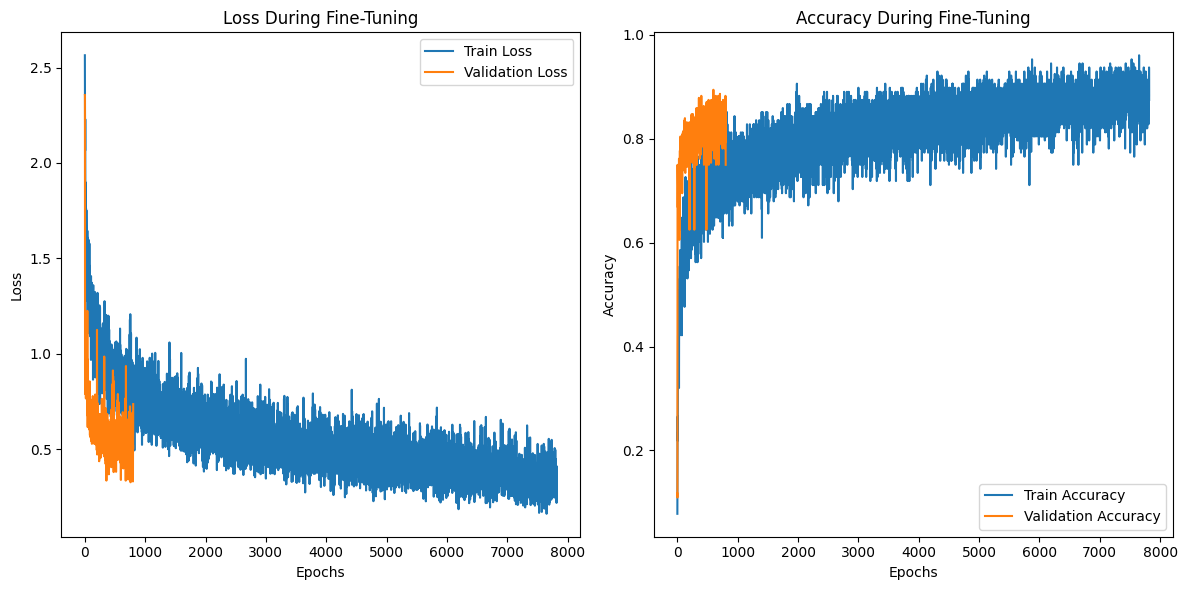

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8337000012397766     │
│         test_loss         │     0.532495379447937     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8337000012397766, 'test_loss': 0.532495379447937}]

In [30]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Define the Transfer Learning Model (ResNet18)
class ResNet18TransferLearning(L.LightningModule):
    def __init__(self, num_classes=10, pretrained_model=None):
        super().__init__()

        # Load the pre-trained ResNet18 model (pre-trained on Imagenette)
        self.resnet18 = models.resnet18(pretrained=False)  # We don't load pretrained by default here

        if pretrained_model is not None:
            # Load the pre-trained weights from Imagenette
            self.resnet18.load_state_dict(pretrained_model.state_dict())

        # Modify the final fully connected layer to match CIFAR10 (10 classes)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

        # Accuracy metric
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        # To track metrics for plotting
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def forward(self, x):
        return self.resnet18(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        accuracy = self.accuracy(y_hat, y)

        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_accuracy", accuracy, on_step=True, on_epoch=True, prog_bar=True)

        # Store metrics for plotting
        self.train_losses.append(loss.item())
        self.train_accuracies.append(accuracy.item())

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        accuracy = self.accuracy(y_hat, y)

        # Log metrics
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_accuracy", accuracy, on_step=True, on_epoch=True, prog_bar=True)

        # Store metrics for plotting
        self.val_losses.append(loss.item())
        self.val_accuracies.append(accuracy.item())

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        accuracy = self.accuracy(y_hat, y)

        # Log metrics
        self.log("test_accuracy", accuracy)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        # Using Adam optimizer with a learning rate of 1e-3
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Image transformations for CIFAR10 dataset
train_transforms_cifar = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

test_transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# Load CIFAR10 dataset
train_dataset_cifar = CIFAR10(root="data/cifar10", train=True, download=True, transform=train_transforms_cifar)
test_dataset_cifar = CIFAR10(root="data/cifar10", train=False, download=True, transform=test_transforms_cifar)

train_loader = DataLoader(train_dataset_cifar, batch_size=128, num_workers=8, shuffle=True)
test_loader = DataLoader(test_dataset_cifar, batch_size=256, num_workers=8, shuffle=False)

# Load pre-trained ResNet18 model (trained on Imagenette)
pretrained_resnet18_model = models.resnet18(pretrained=True)

# Initialize the transfer learning model with pre-trained weights
model_transfer_learning = ResNet18TransferLearning(num_classes=10, pretrained_model=pretrained_resnet18_model)

# Early stopping callback
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)

# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

# Trainer
trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback], max_epochs=20)

# Fit the model
trainer.fit(model_transfer_learning, train_dataloaders=train_loader, val_dataloaders=test_loader)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(model_transfer_learning.train_losses, label="Train Loss")
plt.plot(model_transfer_learning.val_losses, label="Validation Loss")
plt.title("Loss During Fine-Tuning")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(model_transfer_learning.train_accuracies, label="Train Accuracy")
plt.plot(model_transfer_learning.val_accuracies, label="Validation Accuracy")
plt.title("Accuracy During Fine-Tuning")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on the test set
trainer.test(model=model_transfer_learning, dataloaders=test_loader)
